Notes:
 * same as 17, but with extra scalar features, STD for double/half period views, double period individual transits

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/extended_26_run_18'
data_files = '/mnt/tess/astronet/tfrecords-26-val/*'
tces_file = '/mnt/tess/astronet/tces-v7-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/extended_26_run_18/1/AstroCNNModel_extended_20210829_140416',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/2/AstroCNNModel_extended_20210829_143642',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/3/AstroCNNModel_extended_20210829_150959',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/4/AstroCNNModel_extended_20210829_154458',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/5/AstroCNNModel_extended_20210829_161825',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/6/AstroCNNModel_extended_20210829_165135',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/7/AstroCNNModel_extended_20210829_172520',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/8/AstroCNNModel_extended_20210829_175801',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/9/AstroCNNModel_extended_20210829_183624',
 '/mnt/tess/astronet/checkpoints/extended_26_run_18/10/AstroCNNModel_extended_20210829_190958']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 2
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 3
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 4
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 5
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 6
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 7
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 8
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 9
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records
Running model 10
Binary prediction threshold: 0.2152499407880693 (orientative)
2228 records


In [52]:
labels = ['disp_E', 'disp_N', 'disp_J', 'disp_S', 'disp_B']

col_e = labels.index('disp_E')
thresh = config.hparams.prediction_threshold
thresh = 0.3

In [53]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_E')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [54]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [55]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [56]:
ppos = (pl['disp_E_p'] > 0)
pos = (pl['disp_E'] > 0)

pneg = (pl['disp_E_p'] == 0)
neg = (pl['disp_E'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9739130434782609
Precision: 0.7832167832167832


In [57]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

118412801
141753278
158159741
276978548
349412074
404220255


In [59]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

113496703
118398402
201601338
219945452
276738707
278413697
279475851
281578420
291374558
299945796
311103813
319865847
320356995
326693475
363404187
373919592
384341508
384740598
404733023
404851508
404851552
404851966
404934011
40602499
406971913
407615704
446698252
466098383
283330382
375927073
14209654
188258751
267924099
356776209
136651206
371070027
395164445
417208086
469465627
186483050
252588526
431338538
192591652
198555242
279064110
468608862
127846210
21133246
261814771
269291226
408945155
648359612
82242456
56861756
138847344
97487520
159636125
230197530
284266496
298647682
27896467
405687343


In [63]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 404220255)

,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,
404220255,0.033367,0.077519,0.180121,0.010056,0.906537
404220255,0.013797,0.088868,0.285476,0.004498,0.902807
404220255,0.013685,0.081640,0.438843,0.003629,0.871949
404220255,0.044388,0.081090,0.253320,0.006751,0.832106
404220255,0.015785,0.077666,0.274483,0.003099,0.905408
404220255,0.070875,0.080141,0.141413,0.006552,0.846100
404220255,0.026953,0.082739,0.247282,0.006873,0.899505
404220255,0.054814,0.085567,0.165434,0.012717,0.886349
404220255,0.039566,0.079213,0.205911,0.007287,0.875733


In [11]:
pl[pl.index == 421845505]

,disp_E_p,disp_N_p,disp_J_p,disp_S_p,disp_B_p,maxcount,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,,,,,,,


### PR curve

In [12]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_E']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [13]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9749829210844815, max R: 1.0, max P: 1.0
100% recall at: 64%, threshold: 0.06799761581426361


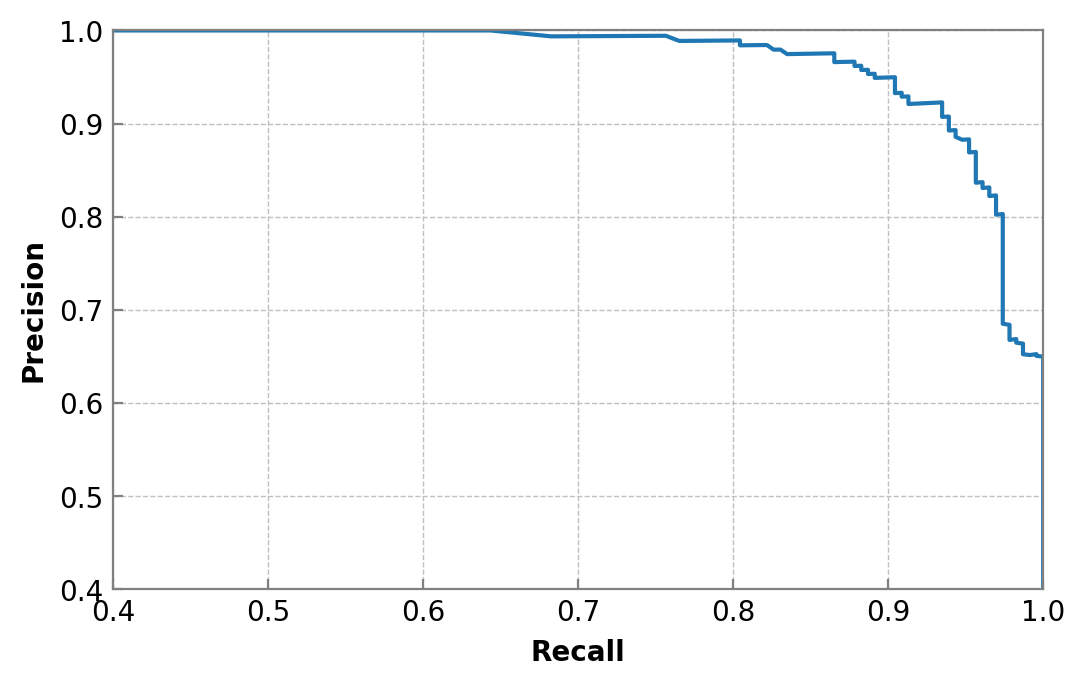

In [14]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.4, 1.0))
plt.ylim((0.4, 1.0))

_ = plt.plot(rs, ps)